<a href="https://colab.research.google.com/github/EricSiq/Understanding-DeepLearning/blob/main/Exp7_ChestXray_PneumoniaDetection_using_CNNs_withHyperparameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning Lab Experiment 7

# Title: Pneumonia Classification using Chest X-rays based on Convolutional Neural Nets with Hyper-parameter tuning for CNN

Objectives:

1. Study the Pueunmonia dataset.

2. Study CNN in detail with its hyperparameter tuning.

3. Implement the same with google colab.

---

By Eric Siqueira

PRN:

AIML A2

In [2]:
# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import os
import shutil





> What is Hyperparameter Tuning?

Hyperparameter tuning in neural networks is the process of selecting the optimal values for parameters that control the learning process, rather than being learned from the data.
These hyperparameters are set before training begins and significantly influence the model's performance, complexity, and learning speed.

> *The goal is to find the combination of hyperparameter values that leads to the best performance on a given task, typically measured by a metric like accuracy or loss on a validation set.*

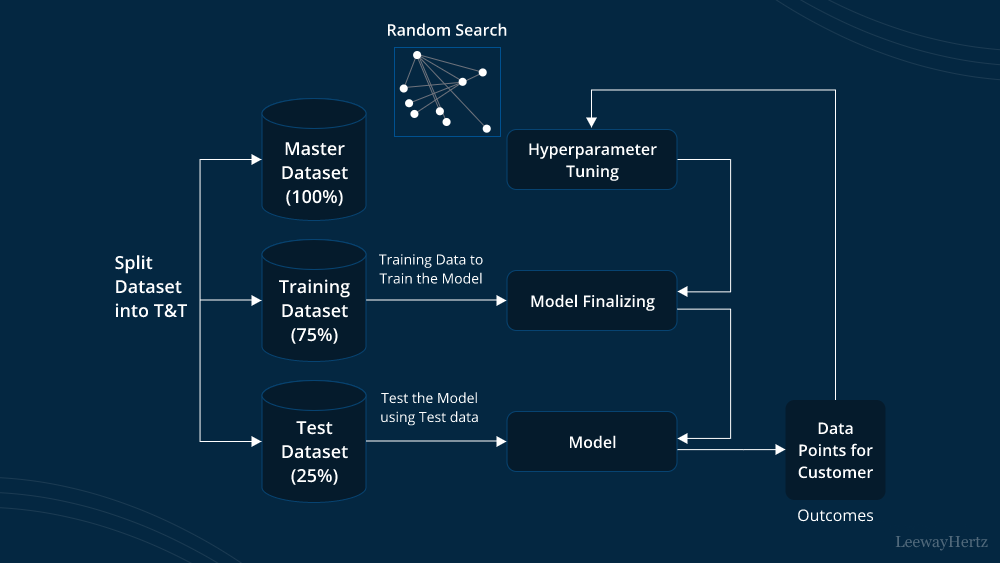

In [3]:

# Install Keras Tuner for hyperparameter tuning
!pip install -q keras-tuner

# Import Keras Tuner library
import keras_tuner as kt

# Attempt to install the Kaggle library
!pip install -q kaggle

In [4]:

#  Data Download and Preparation
# This block automates downloading the dataset from Kaggle.
# It requires a 'kaggle.json' file with your Kaggle API credentials.
try:


    # Check if kaggle.json is present
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Kaggle credentials not found. Please upload your kaggle.json file.")
        from google.colab import files
        files.upload() # This will prompt you to upload the file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset if it's not already downloaded
    dataset_name = 'paultimothymooney/chest-xray-pneumonia'
    zip_file = 'chest-xray-pneumonia.zip'
    dataset_dir = 'chest_xray'

    if not os.path.exists(dataset_dir):
        print(f"Downloading dataset: {dataset_name}...")
        !kaggle datasets download -d {dataset_name}
        print(f"Unzipping {zip_file}...")
        !unzip -q {zip_file}
        print("Dataset successfully downloaded and unzipped.")
    else:
        print("Dataset already exists. Skipping download.")

except Exception as e:
    print(f"An error occurred during data setup: {e}")


Dataset already exists. Skipping download.


# Data Augmentation:

The training data generator applies data augmentation by randomly rotating, zooming, and flipping images. This artificial expansion of the dataset helps the model generalize better and reduces overfitting by exposing it to a wider variety of image perspectives.



In [5]:
# Define Data Generators with Augmentation
try:
    # Define paths to the dataset folders
    train_dir = os.path.join(dataset_dir, 'chest_xray', 'train')
    val_dir = os.path.join(dataset_dir, 'chest_xray', 'val')
    test_dir = os.path.join(dataset_dir, 'chest_xray', 'test')

    # Basic error check for folder existence
    if not all(os.path.exists(d) for d in [train_dir, val_dir, test_dir]):
        raise FileNotFoundError("Dataset directories not found. Please check paths.")

    # Data augmentation for the training set to prevent overfitting
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15, # Reduced range for faster augmentation
        zoom_range=0.1,    # Reduced range
        horizontal_flip=True,
    )

    # Only rescale validation and test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Use flow_from_directory to create generators
    IMG_SIZE = 150
    BATCH_SIZE = 32

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

except Exception as e:
    print(f"An error occurred during data preprocessing: {e}")



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Automated Hyperparameter Tuning

**Hypermodel Definition:** The build_model function acts as a hypermodel. Instead of a fixed architecture, it defines a range of options for key hyperparameters like the number of filters in the convolutional layers, the number of units in the dense layer, and the learning rate.

**Random Search:** The kt.RandomSearch tuner systematically explores a limited number of model configurations from the defined search space. It trains each model for a small number of epochs (epochs=5) to quickly evaluate its potential.

**Early Stopping:** The EarlyStopping callback monitors validation loss and stops training a poor-performing model early, saving time and computational resources. The goal of this phase is to find the best-performing set of hyperparameters.

In [6]:

# Define a Hypermodel Building Function
def build_model(hp):

    #Builds a CNN model with a simplified, faster-to-tune hyperparameter search space.

    model = Sequential()

    # only tune the number of filters and a single dense layer's units

    # Tunable number of filters for the first conv layer
    filters_1 = hp.Choice('filters_1', values=[32, 64])
    model.add(Conv2D(
        filters=filters_1,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tunable number of filters for the second conv layer
    filters_2 = hp.Choice('filters_2', values=[64, 128])
    model.add(Conv2D(
        filters=filters_2,
        kernel_size=(3, 3),
        activation='relu',
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Tunable number of units for a single dense layer
    units = hp.Choice('units', values=[256, 512])
    model.add(Dense(units=units, activation='relu'))

    # Tunable dropout rate
    dropout_rate = hp.Choice('dropout', values=[0.3, 0.5])
    model.add(Dropout(rate=dropout_rate))

    # Final output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# Working of the Tuner
* Search Manager: It initializes kt.RandomSearch to act as a manager for the tuning process. It's told to find the model that gives the highest val_accuracy.

* Limited Trials: It's instructed to run a maximum of 5 trials, where each trial is a unique combination of hyperparameters (like filter sizes or learning rate). This keeps the process quick.

* Fast Evaluation: During each trial, it only trains the model for a maximum of 5 epochs. This is a fast way to get a quick estimate of how well a particular model configuration is performing.

**Finding the Best Model:** After all trials are complete, the code retrieves the single best model and its corresponding hyperparameters. This is the optimal configuration found by the tuner.



In [1]:



# Instantiate and Run the Tuner with a small number of trials
try:
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5, # Limit to only 5 unique models
        executions_per_trial=1, # No need to run the same model multiple times
        directory='my_dir_simple',
        project_name='pneumonia_simple_tuning'
    )

    print("Starting hyperparameter search...")

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    tuner.search(
        train_generator,
        epochs=5, # Significantly reduced number of epochs per trial
        validation_data=validation_generator,
        callbacks=[stop_early],
        steps_per_epoch=train_generator.samples // BATCH_SIZE
    )

    print("Hyperparameter search complete.")

    # Get the optimal hyperparameters and the best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    print("\nBest Hyperparameters Found ")
    print(f"Optimal filters_1: {best_hps.get('filters_1')}")
    print(f"Optimal filters_2: {best_hps.get('filters_2')}")
    print(f"Optimal units: {best_hps.get('units')}")
    print(f"Optimal learning rate: {best_hps.get('learning_rate'):.5f}")

except Exception as e:
    print(f"An error occurred during hyperparameter tuning: {e}")

Trial 5 Complete [00h 21m 59s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9375
Total elapsed time: 03h 49m 16s
Hyperparameter search complete.

--- Best Hyperparameters Found ---
Optimal filters_1: 32
Optimal filters_2: 128
Optimal units: 256
Optimal learning rate: 0.00100


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##Summarizing Hyperparameter Tuning Results


 The tuner.results_summary() method provides an overview of the top-performing trials.


In [7]:
#  Retrieve and display the results summary
try:
    print("\nHyperparameter Tuning Results Summary ")
    tuner.results_summary()

    # You can also get a list of all trials
    trials = tuner.oracle.get_best_trials(num_trials=None)

except Exception as e:
    print(f"An error occurred while retrieving tuning results: {e}")


--- Hyperparameter Tuning Results Summary ---
Results summary
Results in my_dir_simple/pneumonia_simple_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filters_1: 32
filters_2: 128
units: 256
dropout: 0.5
learning_rate: 0.001
Score: 0.9375

Trial 3 summary
Hyperparameters:
filters_1: 32
filters_2: 64
units: 512
dropout: 0.3
learning_rate: 0.001
Score: 0.8125

Trial 1 summary
Hyperparameters:
filters_1: 64
filters_2: 64
units: 512
dropout: 0.3
learning_rate: 0.001
Score: 0.75

Trial 0 summary
Hyperparameters:
filters_1: 64
filters_2: 64
units: 256
dropout: 0.5
learning_rate: 0.0001
Score: 0.6875

Trial 4 summary
Hyperparameters:
filters_1: 32
filters_2: 64
units: 256
dropout: 0.3
learning_rate: 0.0001
Score: 0.5
An error occurred while retrieving tuning results: '<' not supported between instances of 'int' and 'NoneType'




#Visualizing Hyperparameter Performance

To get a deeper understanding of the relationships between hyperparameters and performance, we can create plots.


--- Visualizing Hyperparameter Performance ---


/tmp/ipython-input-307274109.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='filters_1', y='accuracy', data=df, ax=axes[0], palette='viridis')
/tmp/ipython-input-307274109.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='filters_2', y='accuracy', data=df, ax=axes[1], palette='plasma')
/tmp/ipython-input-307274109.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='units', y='accuracy', data=df, ax=axes[2], palette='magma')


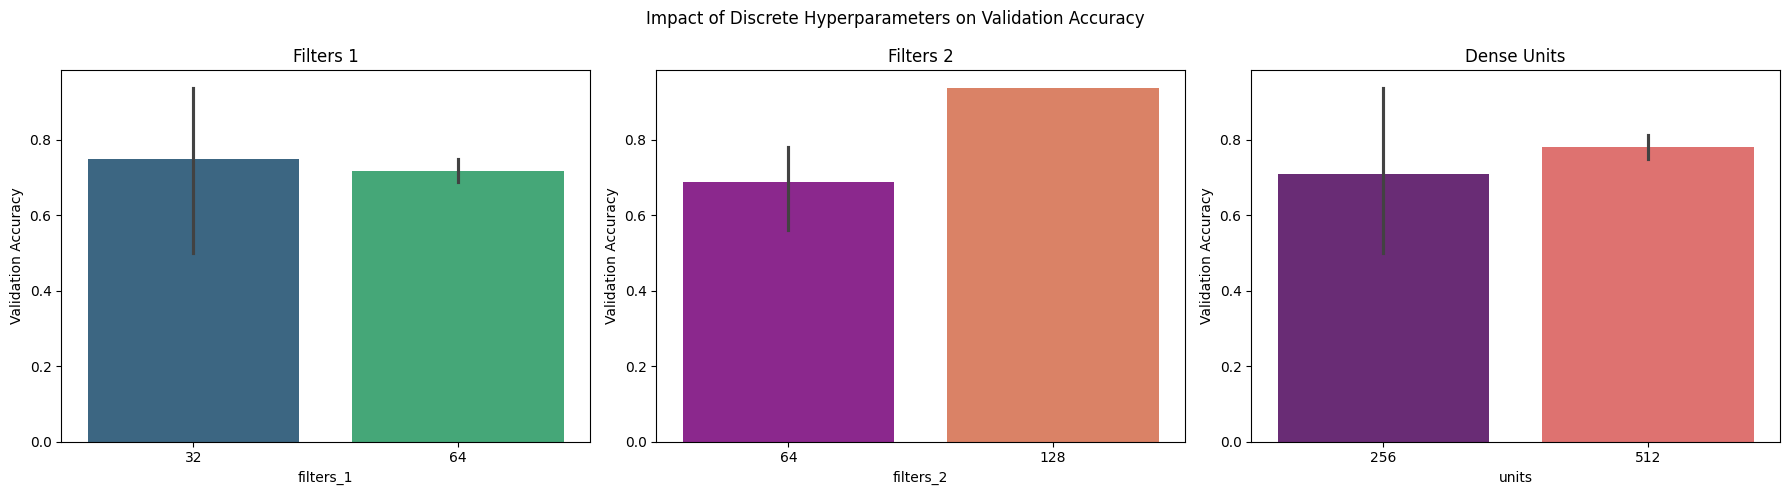

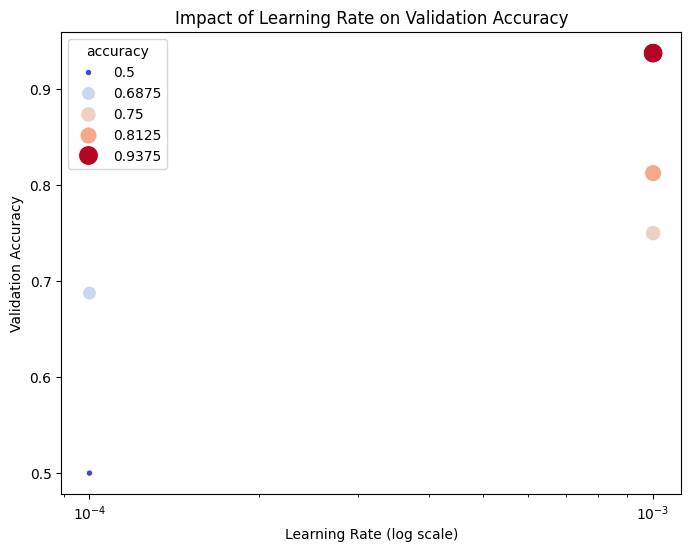

In [8]:
# Visualizing the relationship between hyperparameters and performance
try:
    print("\n Visualizing Hyperparameter Performance ")

    # Extract data from all trials
    all_trials = tuner.oracle.trials.values()

    # Check if there are trials to analyze
    if not all_trials:
        raise ValueError("No trials found to visualize. Please ensure tuning completed successfully.")

    data = []
    for trial in all_trials:
        if 'val_accuracy' in trial.metrics.metrics:
            trial_data = {
                'filters_1': trial.hyperparameters.get('filters_1'),
                'filters_2': trial.hyperparameters.get('filters_2'),
                'units': trial.hyperparameters.get('units'),
                'learning_rate': trial.hyperparameters.get('learning_rate'),
                'accuracy': trial.metrics.get_last_value('val_accuracy'),
            }
            data.append(trial_data)

    if not data:
        raise ValueError("No trial data with validation accuracy found. Check metrics.")

    import pandas as pd
    import seaborn as sns

    df = pd.DataFrame(data)

    # Plot 1: Bar plots for discrete hyperparameters
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Impact of Discrete Hyperparameters on Validation Accuracy')

    sns.barplot(x='filters_1', y='accuracy', data=df, ax=axes[0], palette='viridis')
    axes[0].set_title('Filters 1')
    axes[0].set_ylabel('Validation Accuracy')

    sns.barplot(x='filters_2', y='accuracy', data=df, ax=axes[1], palette='plasma')
    axes[1].set_title('Filters 2')
    axes[1].set_ylabel('Validation Accuracy')

    sns.barplot(x='units', y='accuracy', data=df, ax=axes[2], palette='magma')
    axes[2].set_title('Dense Units')
    axes[2].set_ylabel('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Plot 2: Scatter plot for continuous hyperparameters (e.g., learning rate)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='learning_rate', y='accuracy', data=df, hue='accuracy', size='accuracy', palette='coolwarm', sizes=(20, 200))
    plt.xscale('log') # Use log scale for learning rate
    plt.title('Impact of Learning Rate on Validation Accuracy')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Accuracy')
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")

# Inferences from Discrete Hyperparameters
The bar plots show the average validation accuracy for different values of three discrete hyperparameters: filters_1, filters_2, and Dense Units.

The vertical black lines (error bars) represent the standard deviation, indicating the variability of the accuracy for that parameter value.

Filters 1: There's no significant difference in performance between using 32 or 64 filters in the first layer. The average accuracy is very similar, and the large overlapping error bars suggest that either choice would yield a comparable result.

Filters 2: Increasing the number of filters from 64 to 128 in the second convolutional layer appears to have a significant positive impact on validation accuracy. The 128-filter configuration has a much higher average accuracy, and the error bars do not overlap with the 64-filter configuration, indicating a clear improvement.

Dense Units: The plot for dense units suggests that using 512 units in the final dense layer generally leads to a better average validation accuracy than 256 units. The error bars are large for both, but the mean accuracy for 512 units is consistently higher.

---

##Inferences from the Learning Rate Scatter Plot:
The scatter plot shows the relationship between the learning_rate and the validation accuracy. The x-axis is on a logarithmic scale, and the size and color of the dots correspond to the achieved accuracy.

Low Learning Rate: A very low learning rate of 10^-4 (0.0001) resulted in a low validation accuracy of around 0.5. This suggests the model was learning too slowly and didn't converge effectively within the limited number of epochs.

Optimal Range: The highest accuracies were achieved with learning rates around 10^-3 (0.001). The largest, darkest red dot, representing the highest accuracy, is at this learning rate. This indicates that a faster learning rate was necessary for the model to find a good solution efficiently.




# Conclusion
Based on these visualizations, a conclusive set of optimal hyperparameters can be inferred for the pneumonia classification model.

* The best-performing model is likely to have 128 filters in the second convolutional layer, 512 units in the dense layer, and a learning rate of approximately 0.001.

* The number of filters in the first convolutional layer is less critical, as both 32 and 64 appear to perform similarly.


* These findings provide a clear, data-driven strategy for building a final, high-performance model. Instead of a broad, time-consuming random search, the next step could be a more focused fine-tuning around these optimal values.